<a href="https://colab.research.google.com/github/INFJakZda/Emotion-Recognition/blob/master/reports/Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importowanie bibliotek

In [45]:
import argparse
import io
import json
import os
import re
import numpy as np
from matplotlib import pyplot as plt

from pylab import rcParams

import tensorflow as tf
print(tf.__version__)

from keras import optimizers
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical


2.3.0


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Funkcje pomocnicze

## Definicja stałych

In [37]:
EMBEDDING_DIM=100
LSTM_DIM=120
NUM_CLASSES=4
MAX_SEQUENCE_LENGTH=200
DROPOUT=0.2
LEARNING_RATE=0.003
NUM_FOLDS=5
MAX_NB_WORDS=20000
BATCH_SIZE=200
NUM_EPOCHS=100

## Funkcje

In [38]:
def getOneLayerLSTM(embeddingMatrix):
    """Constructs the architecture of the model
    Input:
        embeddingMatrix : The embedding matrix to be loaded in the embedding layer.
    Output:
        model : A basic LSTM model
    """
    embeddingLayer = Embedding(embeddingMatrix.shape[0],
                               EMBEDDING_DIM,
                               weights=[embeddingMatrix],
                               input_length=MAX_SEQUENCE_LENGTH,
                               trainable=False)
    model = Sequential()
    model.add(embeddingLayer)
    model.add(LSTM(LSTM_DIM, dropout=DROPOUT))
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    rmsprop = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)
    model.compile(loss='categorical_crossentropy',
                  optimizer=rmsprop,
                  metrics=['acc'])
    return model

In [17]:
def preprocessData(dataFilePath, mode, eos=" <eos> "):
    """Load data from a file, process and return indices, conversations and labels in separate lists
    Input:
        dataFilePath : Path to train/test file to be processed
        mode : "train" mode returns labels. "test" mode doesn't return labels.
    Output:
        indices : Unique conversation ID list
        conversations : List of 3 turn conversations, processed and each turn separated by the <eos> tag
        labels : [Only available in "train" mode] List of labels
    """
    indices = []
    conversations = []
    labels = []
    with io.open(dataFilePath, encoding="utf8") as finput:
        finput.readline()
        for line in finput:
            # Convert multiple instances of . ? ! , to single instance
            # okay...sure -> okay . sure
            # okay???sure -> okay ? sure
            # Add whitespace around such punctuation
            # okay!sure -> okay ! sure
            repeatedChars = ['.', '?', '!', ',']
            for c in repeatedChars:
                lineSplit = line.split(c)
                while True:
                    try:
                        lineSplit.remove('')
                    except:
                        break
                cSpace = ' ' + c + ' '
                line = cSpace.join(lineSplit)

            line = line.strip().split('\t')
            if mode == "train":
                # Train data contains id, 3 turns and label
                label = emotion2label[line[4]]
                labels.append(label)

            conv = f'{eos}'.join(line[1:4])

            # Remove any duplicate spaces
            duplicateSpacePattern = re.compile(r'\ +')
            conv = re.sub(duplicateSpacePattern, ' ', conv)

            indices.append(int(line[0]))
            conversations.append(conv.lower())

    if mode == "train":
        return indices, conversations, labels
    else:
        return indices, conversations

In [18]:
def getEmbeddingMatrix(wordIndex):
    """Populate an embedding matrix using a word-index. If the word "happy" has an index 19,
       the 19th row in the embedding matrix should contain the embedding vector for the word "happy".
    Input:
        wordIndex : A dictionary of (word : index) pairs, extracted using a tokeniser
    Output:
        embeddingMatrix : A matrix where every row has 100 dimensional GloVe embedding
    """
    embeddingsIndex = {}
    # Load the embedding vectors from ther GloVe file
    with io.open(gloveDir, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            embeddingVector = np.asarray(values[1:], dtype='float32')
            embeddingsIndex[word] = embeddingVector

    print('Found %s word vectors.' % len(embeddingsIndex))

    # Minimum word index of any word is 1. 
    embeddingMatrix = np.zeros((len(wordIndex) + 1, EMBEDDING_DIM))
    for word, i in wordIndex.items():
        embeddingVector = embeddingsIndex.get(word)
        if embeddingVector is not None:
            # words not found in embedding index will be all-zeros.
            embeddingMatrix[i] = embeddingVector

    return embeddingMatrix

# Kod wykonawczy

In [20]:
mainPath = '/content/drive/My Drive/Magisterka/'

trainDataPath = mainPath + 'train.txt'
devDataPath = mainPath + 'test.txt'
testDataPath = mainPath + 'test.txt'

solutionPath = mainPath + 'solution/'

gloveDir = mainPath + 'glove.6B.100d.txt'

label2emotion = {0: "others", 1: "happy", 2: "sad", 3: "angry"}
emotion2label = {"others": 0, "happy": 1, "sad": 2, "angry": 3}

## Przetwarzanie danych

In [21]:
trainIndices, trainTexts, trainLabels = preprocessData(trainDataPath, mode="train")
devIndices, devTexts, devLabels = preprocessData(devDataPath, mode="train")
testIndices, testTexts, testLabels = preprocessData(testDataPath, mode="train")

In [22]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(trainTexts)

trainSequences = tokenizer.texts_to_sequences(trainTexts)
devSequences = tokenizer.texts_to_sequences(devTexts)
testSequences = tokenizer.texts_to_sequences(testTexts)

In [23]:
wordIndex = tokenizer.word_index
embeddingMatrix = getEmbeddingMatrix(wordIndex)

Found 400000 word vectors.


In [24]:
dataTrain = pad_sequences(trainSequences, maxlen=MAX_SEQUENCE_LENGTH)
dataDev = pad_sequences(devSequences, maxlen=MAX_SEQUENCE_LENGTH)
dataTest = pad_sequences(testSequences, maxlen=MAX_SEQUENCE_LENGTH)

trainLabels = to_categorical(np.asarray(trainLabels))
devLabels = to_categorical(np.asarray(devLabels))
testLabels = to_categorical(np.asarray(testLabels))

## Budowa i ewaluacja modeli

### Jednowarstwowy LSTM

In [25]:
model = getOneLayerLSTM(embeddingMatrix)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          1683200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 120)               106080    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 484       
Total params: 1,789,764
Trainable params: 106,564
Non-trainable params: 1,683,200
_________________________________________________________________


In [26]:
history = model.fit(dataTrain, trainLabels, validation_data=(dataDev, devLabels), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
model.save(mainPath + 'EP%d_LR%de-5_LDim%d_BS%d.h5' % (NUM_EPOCHS, int(LEARNING_RATE * (10 ** 5)), LSTM_DIM, BATCH_SIZE))

Epoch 1/100
151/151 [==============================] - 10s 66ms/step - loss: 0.8590 - acc: 0.6561 - val_loss: 0.4092 - val_acc: 0.8689
Epoch 2/100
151/151 [==============================] - 9s 62ms/step - loss: 0.5956 - acc: 0.7719 - val_loss: 0.3781 - val_acc: 0.8698
Epoch 3/100
151/151 [==============================] - 9s 63ms/step - loss: 0.4990 - acc: 0.8118 - val_loss: 0.4711 - val_acc: 0.8230
Epoch 4/100
151/151 [==============================] - 9s 62ms/step - loss: 0.4450 - acc: 0.8330 - val_loss: 0.3612 - val_acc: 0.8733
Epoch 5/100
151/151 [==============================] - 9s 62ms/step - loss: 0.4083 - acc: 0.8472 - val_loss: 0.4165 - val_acc: 0.8517
Epoch 6/100
151/151 [==============================] - 9s 63ms/step - loss: 0.3779 - acc: 0.8588 - val_loss: 0.3699 - val_acc: 0.8695
Epoch 7/100
151/151 [==============================] - 9s 62ms/step - loss: 0.3538 - acc: 0.8664 - val_loss: 0.3761 - val_acc: 0.8648
Epoch 8/100
151/151 [==============================] - 9s 62m

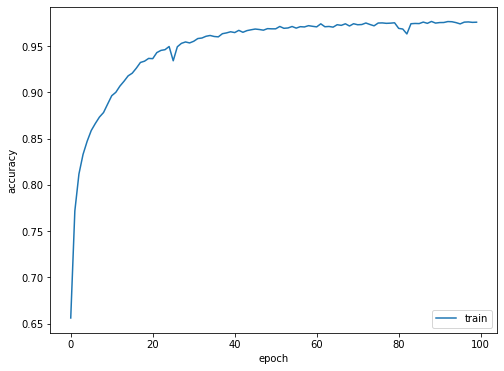

In [51]:
rcParams['figure.figsize'] = 8,6
plt.plot(history.history['acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='lower right')
plt.show()

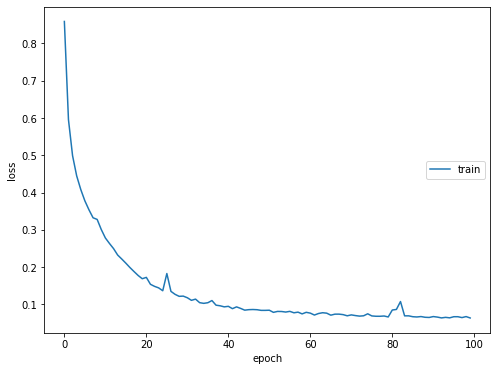

In [52]:
rcParams['figure.figsize'] = 8,6
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='right')
plt.show()

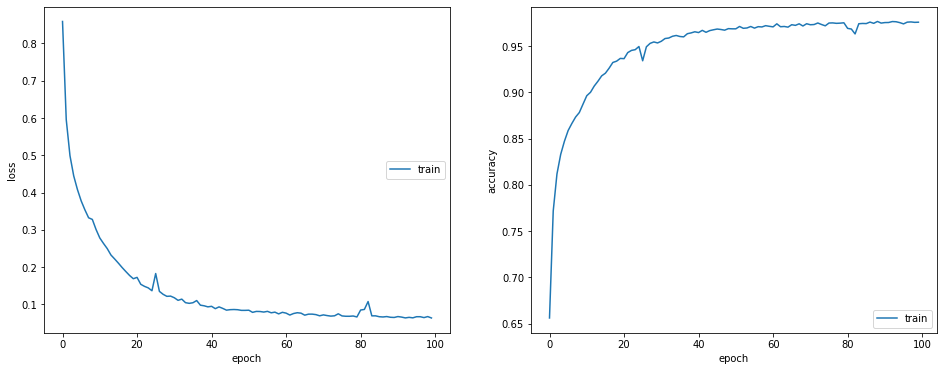

In [50]:
rcParams['figure.figsize'] = 16, 6

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history['loss'])
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train'], loc='right')
ax2.plot(history.history['acc'])
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train'], loc='lower right')

### Głęboki LSTM